## Estimating LDA with Bank of England Minutes

Here we show the code to re-create figures in Andy Haldane's speech \textit{Central bank psychology} ( http://bit.ly/2G7qoF3), in particular the estimates of the share of time the MPC minutes spend discusing banking.  The figure is below.  A similar notebook (with somewhat more extensive explanation) on state-of-the-union addresses can be found in the text-mining-tutorial repository.

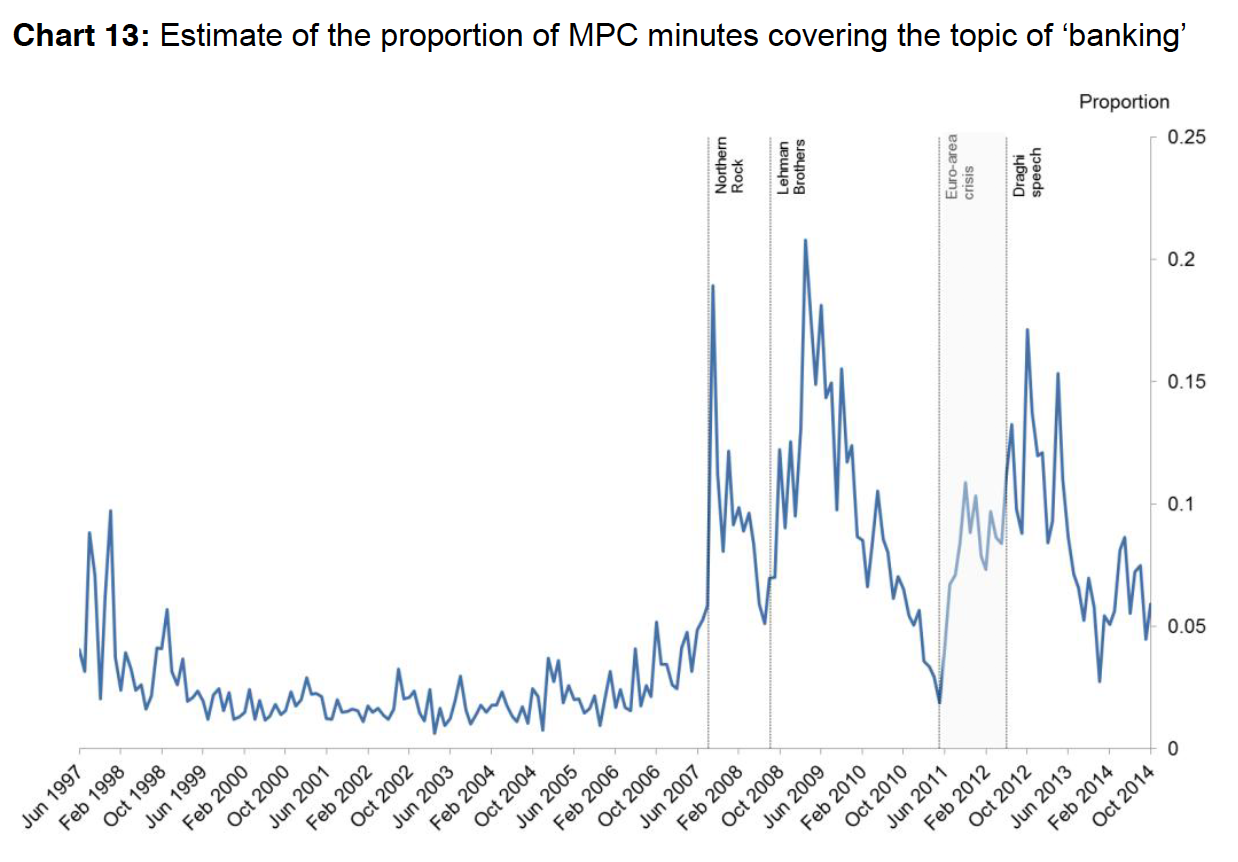

In [1]:
from IPython.display import Image
Image(filename="minutes_banking_share.png", width=700, height=700)

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import topicmodels
import matplotlib.pyplot as plt

First, we load and process MPC minutes exactly as in the information_retrieval notebook.  The reason for repeating the steps is that we treat a document as a single paragraph of the minutes rather than an entire minutes file.

In [3]:
data = pd.read_csv("mpc_minutes.txt", encoding="utf-8", sep="\t")

docsobj = topicmodels.RawDocs(data.minutes, "long")
docsobj.token_clean(1)
docsobj.stopword_remove("tokens")
docsobj.stem()
docsobj.stopword_remove("stems")
docsobj.term_rank("stems")

The first step in estimation is to initialize a model. We will pass docsobj.stems as the set of documents, and we also need to decide on a number of topics. Here we choose 30 topics.

In [4]:
ldaobj = topicmodels.LDA.LDAGibbs(docsobj.stems,30)

There are three main parameters in LDA, the number of topics, and the two hyperparameters of the Dirichlet priors.  We follow the advice of Griffiths and Steyvers (2004) and sets the hyperparameter of the Dirichlet prior on topics to $200/V$, where $V$ is the number of unique vocabulary elements, and the hyperparameter of the Dirichlet prior on document-topic distributions to $50/K$, where $K$ is the number of topics.

In [5]:
print(ldaobj.K) # number of topic, user defined.
print(ldaobj.alpha) # hyperparameter for document-topic distribution, automatically defined
print(ldaobj.beta) # hyperparameter for topics, automatically defined

30
1.6666666666666667
0.03622532149972831


Now that we have initialized our topic model, we are ready to sample. To sample, we pass three parameters. The first is the number of iterations we want the chain to burn in before beginning to sample. The second is a thinning interval, the number of iterations to let the chain run between samples. Allowing for a thinning interval reduces autocorrelation between samples. The third is the number of samples to take. So, for example, if the user passes (2000,50,20) the following will happen. First, the chain will run for 2,000 iterations. Then 20 samples will be taken corresponding to the $\{2050,2100\ldots,2950,3000\}$ iterations for a total of 3000 iterations overall.

In [6]:
ldaobj.sample(2000, 50, 20)

Iteration 10 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 30 of (collapsed) Gibbs sampling
Iteration 40 of (collapsed) Gibbs sampling
Iteration 50 of (collapsed) Gibbs sampling
Iteration 60 of (collapsed) Gibbs sampling
Iteration 70 of (collapsed) Gibbs sampling
Iteration 80 of (collapsed) Gibbs sampling
Iteration 90 of (collapsed) Gibbs sampling
Iteration 100 of (collapsed) Gibbs sampling
Iteration 110 of (collapsed) Gibbs sampling
Iteration 120 of (collapsed) Gibbs sampling
Iteration 130 of (collapsed) Gibbs sampling
Iteration 140 of (collapsed) Gibbs sampling
Iteration 150 of (collapsed) Gibbs sampling
Iteration 160 of (collapsed) Gibbs sampling
Iteration 170 of (collapsed) Gibbs sampling
Iteration 180 of (collapsed) Gibbs sampling
Iteration 190 of (collapsed) Gibbs sampling
Iteration 200 of (collapsed) Gibbs sampling
Iteration 210 of (collapsed) Gibbs sampling
Iteration 220 of (collapsed) Gibbs sampling
Iteration 230 of (collapsed) Gibbs sampli

Iteration 1860 of (collapsed) Gibbs sampling
Iteration 1870 of (collapsed) Gibbs sampling
Iteration 1880 of (collapsed) Gibbs sampling
Iteration 1890 of (collapsed) Gibbs sampling
Iteration 1900 of (collapsed) Gibbs sampling
Iteration 1910 of (collapsed) Gibbs sampling
Iteration 1920 of (collapsed) Gibbs sampling
Iteration 1930 of (collapsed) Gibbs sampling
Iteration 1940 of (collapsed) Gibbs sampling
Iteration 1950 of (collapsed) Gibbs sampling
Iteration 1960 of (collapsed) Gibbs sampling
Iteration 1970 of (collapsed) Gibbs sampling
Iteration 1980 of (collapsed) Gibbs sampling
Iteration 1990 of (collapsed) Gibbs sampling
Iteration 2000 of (collapsed) Gibbs sampling
Iteration 2010 of (collapsed) Gibbs sampling
Iteration 2020 of (collapsed) Gibbs sampling
Iteration 2030 of (collapsed) Gibbs sampling
Iteration 2040 of (collapsed) Gibbs sampling
Iteration 2050 of (collapsed) Gibbs sampling
Iteration 2060 of (collapsed) Gibbs sampling
Iteration 2070 of (collapsed) Gibbs sampling
Iteration 

One simple convergence criterion is whether the perplexity computed at each draw of the Markov chain is stable, which we can compute and verify.  Denote the log-likelihood of the data at sample $s$ as $L = \sum_{d=1}^D\sum_{v=1}^Vx_{d,v}\log\left(\sum_{k=1}^K\widehat{\theta}^{(s)}_{d,k}\widehat{\beta}^{(s)}_{k,v}\right)$.  The perplexity of the data is then $\exp(-L/N)$.

In [7]:
ldaobj.perplexity()

array([436.01559637, 436.14883011, 436.0200655 , 436.07258485,
       436.16102593, 435.87252378, 435.88792829, 435.74221456,
       435.80235893, 435.57099421, 435.84923733, 435.93298247,
       435.60556528, 435.89677162, 435.99762604, 435.94013768,
       435.99744585, 435.90332722, 435.97059167, 436.08417366])

The two key outputs of interest are the posterior distributions for the $\boldsymbol\beta$ topic-term probability vectors and for the $\boldsymbol\theta$ document-topic shares.  We can compute these for each draw of the Markov chain, which are stored in the objects below.

In [8]:
print(ldaobj.tt.shape)
print(ldaobj.dt.shape)

(5521, 30, 20)
(7277, 30, 20)


We can first explore the terms that make up each topic via the call below, which outputs a file with terms in each topic ranked by their average probability across the samples...the user can explore the contents offline.

In [9]:
ldaobj.topic_content(20, output_file="topic_description.csv")

In this particular Markov chain, topic 2 appears to be about banking and financial markets.

In [10]:
k=2
W=20

tt = ldaobj.tt_avg(False)
top_word_indices = list(tt[:, k].argsort()[-W:][::-1])

top_words = [list(ldaobj.token_key.keys())[list(ldaobj.token_key.values()).index(i)] for i in top_word_indices]
top_words_probs = np.round(np.sort(tt[:, k])[-W:][::-1], 3)
print(top_words)
print(top_words_probs)

['bank', 'credit', 'financi', 'lend', 'money', 'condit', 'market', 'corpor', 'compani', 'fund', 'capit', 'borrow', 'sector', 'broad', 'hold', 'spread', 'non', 'household', 'improv', 'cost']
[0.064 0.053 0.041 0.038 0.033 0.031 0.026 0.025 0.024 0.022 0.017 0.017
 0.015 0.015 0.014 0.014 0.012 0.012 0.011 0.011]


For the estimation of LDA, we used individual paragraphs as documents, but most analysis we would naturally be more interested in the distribution of topics at the level of the entire minutes.  To obtain these, we re-estimate topic shares for aggregated documents, holding fixed the estimated $\boldsymbol\beta$ vectors from the LDA estimation above.  The code below outputs a file with the relevant output.

In [11]:
data['temp'] = [' '.join(s) for s in docsobj.stems]
aggspeeches = data.groupby(['year'])['temp'].apply(lambda x: ' '.join(x))
aggdocs = topicmodels.RawDocs(aggspeeches)

queryobj = topicmodels.LDA.QueryGibbs(aggdocs.tokens,
                                      ldaobj.token_key,
                                      ldaobj.tt)
queryobj.query(10)

dt_query = queryobj.dt_avg()
aggdata = pd.DataFrame(dt_query, index=aggspeeches.index,
                       columns=['T' + str(i) for i in range(queryobj.K)])
aggdata.to_csv("final_output_agg.csv")

Sample 0 queried
Sample 1 queried
Sample 2 queried
Sample 3 queried
Sample 4 queried
Sample 5 queried
Sample 6 queried
Sample 7 queried
Sample 8 queried
Sample 9 queried
Sample 10 queried
Sample 11 queried
Sample 12 queried
Sample 13 queried
Sample 14 queried
Sample 15 queried
Sample 16 queried
Sample 17 queried
Sample 18 queried
Sample 19 queried


Now we can plot the time series of the banking topic, and observe it closely resembles that above.

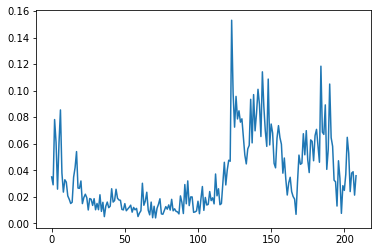

In [12]:
plt.plot(aggdata.T2.values)